# Bikes Analysis
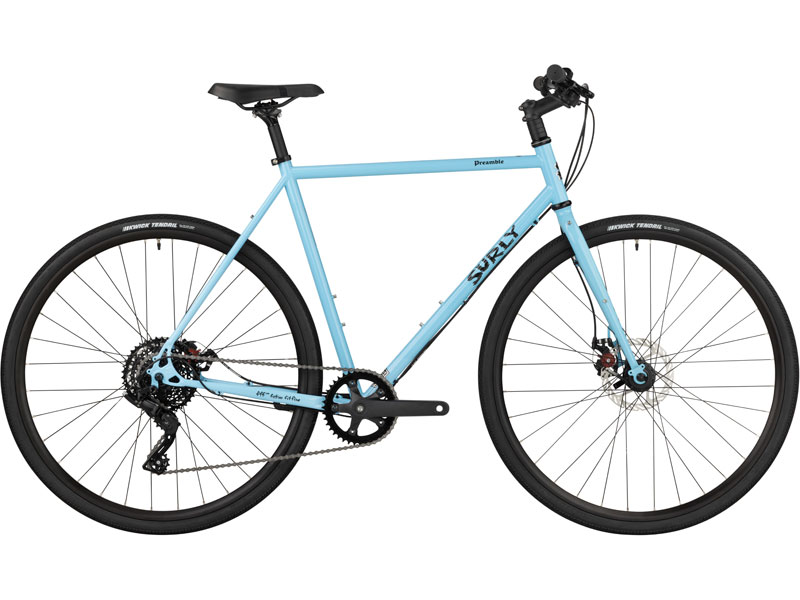![image.png]

# About Dataset
> Data from years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA.

**datetime:** hourly date + timestamp

**season:** spring, summer, fall and  winter

**holiday:** whether the day is considered a holiday

**workingday:** whether the day is neither a weekend nor holiday

**weather:** Clear, Mist, Rainy and Snowy

**temp:** temperature in Celsius

**humidity:** relative humidity

**windspeed:** wind speed

**casual:** number of non-registered user rentals initiated

**registered:** number of registered user rentals initiated

**rented_bikes_count:** number of bikes rented

# Libraries and Models

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':[7, 7]}, font_scale = 1.2)
import matplotlib.pyplot as plt


from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRFRegressor


# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Cross Validation & Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import joblib

# Read Data

In [2]:
df = pd.read_csv("D:\\Courses\\Datasets\\bikes.csv")
df

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0000,8,32,40
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0000,5,27,32
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0000,3,10,13
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0.0,1.0,Clear,15.58,50.0,26.0027,7,329,336
10882,2012-12-19 20:00:00,Winter,0.0,1.0,NaN,14.76,NaN,NaN,10,231,241
10883,2012-12-19 21:00:00,NaN,0.0,1.0,Clear,13.94,61.0,15.0013,4,164,168
10884,2012-12-19 22:00:00,Winter,NaN,1.0,Clear,13.94,NaN,6.0032,12,117,129


#  EDA & Feature Engineering and Extraction

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            10886 non-null  object 
 1   season              10672 non-null  object 
 2   holiday             10030 non-null  float64
 3   workingday          9388 non-null   float64
 4   weather             8746 non-null   object 
 5   temp                8104 non-null   float64
 6   humidity            7462 non-null   float64
 7   windspeed           6820 non-null   float64
 8   casual              10886 non-null  int64  
 9   registered          10886 non-null  int64  
 10  rented_bikes_count  10886 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 935.6+ KB


In [4]:
# Calculate Profit

def calc_profit(x):
    casual_customers = x['casual']
    registered_customers = x['registered']
    registered_price_per_hour = 5
    casual_price_per_hour = 20
    taxes = 0.14
    maintenance_per_hour = 1500/(356*24)
    profit_cash = (casual_customers * casual_price_per_hour) + (registered_customers * registered_price_per_hour)
    profit_with_taxes = profit_cash - (profit_cash * taxes)
    total_profit = profit_with_taxes - maintenance_per_hour
    return total_profit

df['profit'] = df[['casual', 'registered']].apply(calc_profit, axis=1)
df

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,107.324438
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0000,8,32,40,275.024438
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0000,5,27,32,201.924438
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0000,3,10,13,94.424438
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,4.124438
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0.0,1.0,Clear,15.58,50.0,26.0027,7,329,336,1534.924438
10882,2012-12-19 20:00:00,Winter,0.0,1.0,NaN,14.76,NaN,NaN,10,231,241,1165.124438
10883,2012-12-19 21:00:00,NaN,0.0,1.0,Clear,13.94,61.0,15.0013,4,164,168,773.824438
10884,2012-12-19 22:00:00,Winter,NaN,1.0,Clear,13.94,NaN,6.0032,12,117,129,709.324438


In [5]:
df['rented_bikes_count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: rented_bikes_count, dtype: float64

In [6]:
df[df['rented_bikes_count'] == df['rented_bikes_count'].max()]

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit
9345,2012-09-12 18:00:00,Fall,0.0,NaN,Clear,27.06,NaN,16.9979,91,886,977,5374.824438


In [7]:
df['profit'].describe()

count    10886.000000
mean      1288.276422
std       1309.683400
min          4.124438
25%        253.524438
50%        889.924438
75%       1891.824438
max       7881.724438
Name: profit, dtype: float64

In [8]:
df[df['profit'] == df['profit'].max()]

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit
9415,2012-09-15 16:00:00,Fall,0.0,0.0,Mist,NaN,36.0,15.0013,350,433,783,7881.724438


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            10886 non-null  object 
 1   season              10672 non-null  object 
 2   holiday             10030 non-null  float64
 3   workingday          9388 non-null   float64
 4   weather             8746 non-null   object 
 5   temp                8104 non-null   float64
 6   humidity            7462 non-null   float64
 7   windspeed           6820 non-null   float64
 8   casual              10886 non-null  int64  
 9   registered          10886 non-null  int64  
 10  rented_bikes_count  10886 non-null  int64  
 11  profit              10886 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 1020.7+ KB


In [10]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month_name()
df['day_of_week'] = df['datetime'].dt.day_name()
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,107.324438,2011,January,Saturday,1,0
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0000,8,32,40,275.024438,2011,January,Saturday,1,1
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0000,5,27,32,201.924438,2011,January,Saturday,1,2
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0000,3,10,13,94.424438,2011,January,Saturday,1,3
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,4.124438,2011,January,Saturday,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0.0,1.0,Clear,15.58,50.0,26.0027,7,329,336,1534.924438,2012,December,Wednesday,19,19
10882,2012-12-19 20:00:00,Winter,0.0,1.0,NaN,14.76,NaN,NaN,10,231,241,1165.124438,2012,December,Wednesday,19,20
10883,2012-12-19 21:00:00,NaN,0.0,1.0,Clear,13.94,61.0,15.0013,4,164,168,773.824438,2012,December,Wednesday,19,21
10884,2012-12-19 22:00:00,Winter,NaN,1.0,Clear,13.94,NaN,6.0032,12,117,129,709.324438,2012,December,Wednesday,19,22


In [11]:
# Profit for each day per Year
df.groupby('year').describe()[['rented_bikes_count', 'profit']]

rented_bikes_count                                              \
                  count        mean  min   25%    50%    75%    max   
year                                                                  
2011             5422.0  144.223349  1.0  32.0  111.0  210.0  638.0   
2012             5464.0  238.560944  1.0  59.0  199.0  354.0  977.0   

                  profit                                                  \
             std   count         mean       min         25%          50%   
year                                                                       
2011  133.312123  5422.0   990.704003  4.124438  197.624438   683.524438   
2012  208.114003  5464.0  1583.561499  4.124438  343.824438  1216.724438   

                                             
              75%          max          std  
year                                         
2011  1414.524438  5658.624438  1002.181750  
2012  2321.824438  7881.724438  1498.641866

In [12]:
# Profit for each day per Week_day
df.groupby('day_of_week').describe()[['rented_bikes_count', 'profit']].transpose()

day_of_week                    Friday       Monday     Saturday       Sunday  \
rented_bikes_count count  1529.000000  1551.000000  1584.000000  1579.000000   
                   mean    197.844343   190.390716   196.665404   180.839772   
                   min       1.000000     1.000000     1.000000     1.000000   
                   25%      52.000000    39.000000    45.000000    43.000000   
                   50%     167.000000   146.000000   141.500000   119.000000   
                   75%     290.000000   277.500000   309.500000   298.000000   
                   max     900.000000   968.000000   783.000000   757.000000   
                   std     172.518208   180.943376   180.917795   167.022145   
profit             count  1529.000000  1551.000000  1584.000000  1579.000000   
                   mean   1250.480423  1203.491750  1666.248176  1513.397206   
                   min       4.124438     4.124438     4.124438     4.124438   
                   25%     300.824438   249.224438   283.624438   287.924438   
                   50%    1036.124438   954.424438   956.574438   812.524438   
                   75%    1891.824438  1827.324438  2614.224438  2429.324438   
                   max    5908.024438  5594.124438  7881.724438  7034.624438   
                   std    1110.019552  1129.727600  1772.625088  1571.404307   

day_of_week                  Thursday      Tuesday    Wednesday  
rented_bikes_count count  1553.000000  1539.000000  1551.000000  
                   mean    197.296201   189.723847   188.411348  
                   min       1.000000     1.000000     1.000000  
                   25%      44.000000    36.000000    38.000000  
                   50%     155.000000   146.000000   136.000000  
                   75%     280.000000   274.000000   270.500000  
                   max     901.000000   970.000000   977.000000  
                   std     187.606619   186.719673   190.942004  
profit             count  1553.000000  1539.000000  1551.000000  
                   mean   1157.889474  1112.068753  1100.521859  
                   min       4.124438     4.124438     4.124438  
                   25%     236.324438   210.524438   210.524438  
                   50%     911.424438   834.024438   791.024438  
                   75%    1741.324438  1704.774438  1657.474438  
                   max    5533.924438  6338.024438  5447.924438  
                   std    1086.029849  1065.481400  1111.243780

In [13]:
# Profit for each day per Month
df.groupby('month').describe()[['rented_bikes_count', 'profit']].transpose()

month                           April       August     December     February  \
rented_bikes_count count   909.000000   912.000000   912.000000   901.000000   
                   mean    184.160616   234.118421   175.614035   110.003330   
                   min       1.000000     1.000000     1.000000     1.000000   
                   25%      35.000000    67.750000    45.000000    26.000000   
                   50%     133.000000   193.000000   138.000000    78.000000   
                   75%     277.000000   337.250000   257.000000   157.000000   
                   max     822.000000   897.000000   759.000000   539.000000   
                   std     182.417619   197.198461   155.926050   109.802322   
profit             count   909.000000   912.000000   912.000000   901.000000   
                   mean   1356.718058  1655.352728   962.892421   605.947857   
                   min       4.124438    12.724438     4.124438     4.124438   
                   25%     236.324438   460.999438   236.324438   137.424438   
                   50%     868.424438  1433.874438   750.174438   425.524438   
                   75%    1969.224438  2385.249438  1440.324438   868.424438   
                   max    7344.224438  6497.124438  4480.424438  5099.624438   
                   std    1458.515736  1377.196111   867.250141   627.333003   

month                         January         July         June        March  \
rented_bikes_count count   884.000000   912.000000   912.000000   901.000000   
                   mean     90.366516   235.325658   242.031798   148.169811   
                   min       1.000000     1.000000     1.000000     1.000000   
                   25%      20.000000    77.250000    73.750000    26.000000   
                   50%      65.000000   209.500000   206.000000   100.000000   
                   75%     123.000000   358.500000   363.000000   219.000000   
                   max     512.000000   872.000000   869.000000   801.000000   
                   std      95.302518   184.857337   199.628690   155.352814   
profit             count   884.000000   912.000000   912.000000   901.000000   
                   mean    494.227153  1732.356675  1727.627618   995.692030   
                   min       4.124438     4.124438     4.124438     4.124438   
                   25%     107.324438   557.749438   485.724438   150.324438   
                   50%     352.424438  1597.274438  1425.274438   640.524438   
                   75%     671.699438  2600.249438  2575.524438  1393.024438   
                   max    4213.824438  6187.524438  6849.724438  7679.624438   
                   std     550.485928  1347.819769  1486.849128  1160.191715   

month                             May     November      October    September  
rented_bikes_count count   912.000000   911.000000   911.000000   909.000000  
                   mean    219.459430   193.677278   227.699232   233.805281  
                   min       1.000000     1.000000     1.000000     1.000000  
                   25%      56.000000    53.500000    57.000000    58.000000  
                   50%     182.000000   162.000000   180.000000   188.000000  
                   75%     323.500000   284.000000   342.000000   349.000000  
                   max     873.000000   724.000000   948.000000   977.000000  
                   std     189.320173   165.420965   204.079411   208.915910  
profit             count   912.000000   911.000000   911.000000   909.000000  
                   mean   1527.465447  1191.641892  1518.253088  1656.587475  
                   min       4.124438     4.124438     4.124438     8.424438  
                   25%     376.074438   315.874438   382.524438   373.924438  
                   50%    1264.024438   967.324438  1130.724438  1259.724438  
                   75%    2142.299438  1687.574438  2203.574438  2390.624438  
                   max    7795.724438  7034.624438  7864.524438  7881.724438  
              

In [14]:
# Profit for each day per Month_day
df.groupby('day').describe()[['rented_bikes_count', 'profit']].transpose()

day                                1            2            3            4   \
rented_bikes_count count   575.000000   573.000000   573.000000   574.000000   
                   mean    180.333913   183.910995   194.696335   195.705575   
                   min       1.000000     1.000000     1.000000     1.000000   
                   25%      42.500000    40.000000    43.000000    46.000000   
                   50%     134.000000   144.000000   147.000000   149.000000   
                   75%     264.000000   266.000000   299.000000   298.750000   
                   max     891.000000   865.000000   917.000000   901.000000   
                   std     170.449906   175.304293   182.169699   182.029979   
profit             count   575.000000   573.000000   573.000000   574.000000   
                   mean   1183.079743  1234.689883  1334.828103  1381.787504   
                   min       4.124438     4.124438     4.124438     4.124438   
                   25%     262.124438   232.024438   262.124438   280.399438   
                   50%     859.824438   894.224438   877.024438   879.174438   
                   75%    1704.774438  1788.624438  2076.724438  2097.149438   
                   max    6269.224438  6849.724438  6501.424438  5426.424438   
                   std    1177.332622  1271.885406  1336.400290  1375.830088   

day                                5            6            7            8   \
rented_bikes_count count   575.000000   572.000000   574.000000   574.000000   
                   mean    189.765217   189.860140   183.773519   179.041812   
                   min       1.000000     1.000000     1.000000     1.000000   
                   25%      42.000000    36.750000    34.250000    41.000000   
                   50%     148.000000   141.000000   141.000000   129.500000   
                   75%     276.000000   285.500000   284.500000   269.500000   
                   max     900.000000   858.000000   869.000000   862.000000   
                   std     180.372047   180.953230   175.411770   170.562395   
profit             count   575.000000   572.000000   574.000000   574.000000   
                   mean   1264.779743  1256.266396  1222.133149  1200.955274   
                   min       4.124438     4.124438     4.124438     4.124438   
                   25%     236.324438   218.049438   199.774438   240.624438   
                   50%     907.124438   868.424438   883.474438   773.824438   
                   75%    1872.474438  1884.299438  1918.699438  1787.549438   
                   max    5908.024438  7864.524438  7344.224438  6045.624438   
                   std    1242.544971  1314.523774  1258.343572  1257.326762   

day                                9            10           11           12  \
rented_bikes_count count   575.000000   572.000000   568.000000   573.000000   
                   mean    187.897391   195.183566   195.679577   190.675393   
                   min       1.000000     1.000000     1.000000     1.000000   
                   25%      45.000000    38.000000    46.000000    39.000000   
                   50%     141.000000   149.000000   145.500000   136.000000   
                   75%     267.500000   290.250000   278.750000   285.000000   
                   max     872.000000   968.000000   970.000000   977.000000   
                   std     179.950220   185.657028   187.442058   185.514903   
profit             count   575.000000   572.000000   568.000000   573.000000   
                   mean   1259.687047  1316.932480  1310.983769  1251.237004   
                   min       4.124438     4.124438     4.124438     4.124438   
                   25%     259.974438   214.824438   275.024438   223.424438   
                   50%     829.724438   859.824438   926.474438   877.024438   
                   75%    1859.574438  2068.124438  1871.399438  1887.524438   
                   max    6656.224438  6307.924438  7034.624438  6613.224438  

In [15]:
# Which Season that has more registeration & Profit
df.groupby('season').describe()['profit'].transpose()

season,Fall,Spring,Summer,Winter
count,2680.000000,2634.000000,2670.000000,2688.000000
mean,1682.568468,697.146002,1533.244700,1222.470569
min,4.124438,4.124438,4.124438,4.124438
25%,445.949438,128.824438,318.024438,292.224438
50%,1412.374438,436.274438,1212.424438,935.074438
75%,2472.324438,914.649438,2244.424438,1750.999438
max,7881.724438,7679.624438,7795.724438,7864.524438
std,1429.092535,850.960767,1454.120645,1184.508417


In [16]:
df.groupby('season').describe()['rented_bikes_count'].transpose()

season,Fall,Spring,Summer,Winter
count,2680.000000,2634.000000,2670.000000,2688.000000
mean,234.471642,116.089218,214.711610,198.672247
min,1.000000,1.000000,1.000000,1.000000
25%,68.000000,23.000000,47.000000,51.000000
50%,195.000000,78.000000,171.500000,161.000000
75%,348.000000,163.000000,321.750000,294.000000
max,977.000000,801.000000,873.000000,948.000000
std,197.122029,125.353298,192.109412,177.491672


In [17]:
# Which Weather that has more registeration & Profit
df.groupby('weather').describe()['rented_bikes_count'].transpose()

weather,Clear,Mist,Rainy,Snowy
count,5793.000000,2259.000000,693.000000,1.0
mean,204.109442,179.722001,118.741703,164.0
min,1.000000,1.000000,1.000000,164.0
25%,47.000000,40.000000,24.000000,164.0
50%,160.000000,137.000000,73.000000,164.0
75%,302.000000,266.000000,158.000000,164.0
max,977.000000,890.000000,891.000000,164.0
std,187.713187,168.655730,138.911722,NaN


In [18]:
df.groupby('weather').describe()['profit'].transpose()

weather,Clear,Mist,Rainy,Snowy
count,5793.000000,2259.000000,693.000000,1.000000
mean,1391.795973,1171.010051,735.354020,782.424438
min,4.124438,4.124438,4.124438,782.424438
25%,283.624438,244.924438,128.824438,782.424438
50%,1006.024438,834.024438,399.724438,782.424438
75%,2055.224438,1758.524438,932.924438,782.424438
max,7795.724438,7881.724438,5542.524438,782.424438
std,1372.771954,1164.297225,925.280928,NaN


In [19]:
# Correlation between profit and bikes count for all Features
df.drop(['season', 'weather', 'month', 'day_of_week'], axis=1).corr()[['profit', 'rented_bikes_count']]

,profit,rented_bikes_count
datetime,0.269479,0.310187
holiday,0.017410,-0.005827
workingday,-0.150218,0.010940
temp,0.462618,0.391867
humidity,-0.358150,-0.317282
windspeed,0.100205,0.097747
casual,0.902713,0.690414
registered,0.822156,0.970948
rented_bikes_count,0.934490,1.000000
profit,1.000000,0.934490


<Axes: >

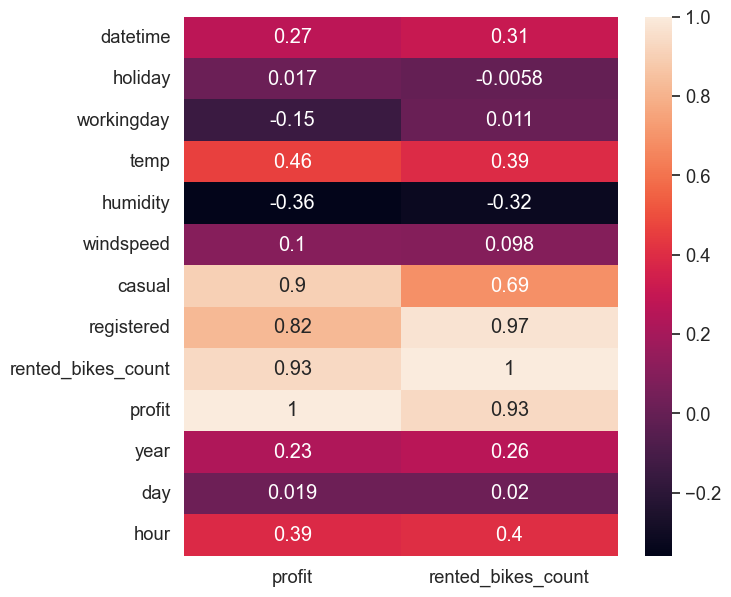

In [20]:
sns.heatmap(df.drop(['season', 'weather', 'month', 'day_of_week'], axis=1).corr()[['profit', 'rented_bikes_count']], annot=True)

In [21]:
# Rentals & Profit during rush hours (7-9 & 3-5)

def is_rush_hour(hour):
    if hour in[7, 8, 9, 15, 16, 17]:
        return (1)
    else:
        return 0
df['is_rush'] = df['hour'].apply(is_rush_hour)
df

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour,is_rush
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,107.324438,2011,January,Saturday,1,0,0
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0000,8,32,40,275.024438,2011,January,Saturday,1,1,0
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0000,5,27,32,201.924438,2011,January,Saturday,1,2,0
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0000,3,10,13,94.424438,2011,January,Saturday,1,3,0
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,4.124438,2011,January,Saturday,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0.0,1.0,Clear,15.58,50.0,26.0027,7,329,336,1534.924438,2012,December,Wednesday,19,19,0
10882,2012-12-19 20:00:00,Winter,0.0,1.0,NaN,14.76,NaN,NaN,10,231,241,1165.124438,2012,December,Wednesday,19,20,0
10883,2012-12-19 21:00:00,NaN,0.0,1.0,Clear,13.94,61.0,15.0013,4,164,168,773.824438,2012,December,Wednesday,19,21,0
10884,2012-12-19 22:00:00,Winter,NaN,1.0,Clear,13.94,NaN,6.0032,12,117,129,709.324438,2012,December,Wednesday,19,22,0


In [22]:
df.groupby('is_rush').describe()['profit'].transpose()

is_rush,0,1
count,8153.000000,2733.000000
mean,1069.670029,1940.416169
min,4.124438,4.124438
25%,158.924438,937.224438
50%,644.824438,1689.724438
75%,1547.824438,2622.824438
max,7864.524438,7881.724438
std,1217.987206,1356.260623


In [23]:
df.groupby('is_rush').describe()['rented_bikes_count'].transpose()

is_rush,0,1
count,8153.000000,2733.000000
mean,153.140562,306.227955
min,1.000000,1.000000
25%,26.000000,157.000000
50%,108.000000,276.000000
75%,225.000000,420.000000
max,977.000000,970.000000
std,158.808647,194.740685


In [24]:
# casual or registered is more Profit?
df.drop(['season', 'weather', 'month', 'day_of_week'], axis=1).corr()[['profit', 'rented_bikes_count']].loc[['casual', 'registered']]

,profit,rented_bikes_count
casual,0.902713,0.690414
registered,0.822156,0.970948


<Axes: >

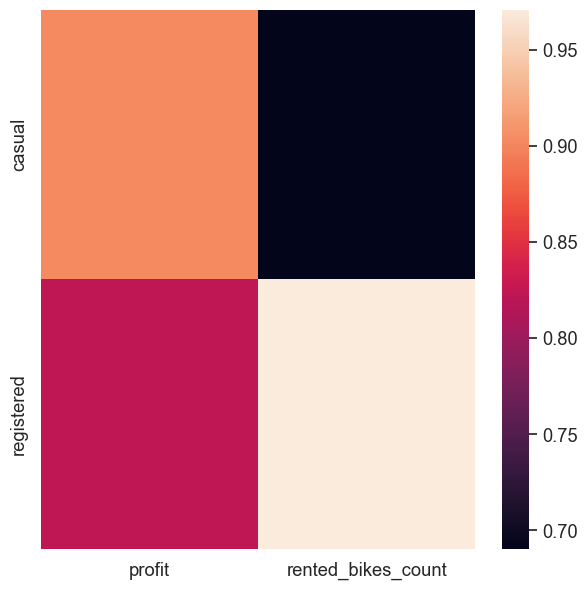

In [25]:
sns.heatmap(df.drop(['season', 'weather', 'month', 'day_of_week'], axis=1).corr()[['profit', 'rented_bikes_count']].loc[['casual', 'registered']])

In [26]:
# School (9-12) & (2-6) profit

df['month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [27]:
def is_school_day(month):
    if month in['September', 'October', 'November', 'December', 'February', 'March', 'April', 'May', 'June']:
        return 1
    else:
        return 0
df['is_school_day'] = df['month'].apply(is_school_day)
df

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour,is_rush,is_school_day
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,107.324438,2011,January,Saturday,1,0,0,0
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0000,8,32,40,275.024438,2011,January,Saturday,1,1,0,0
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0000,5,27,32,201.924438,2011,January,Saturday,1,2,0,0
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0000,3,10,13,94.424438,2011,January,Saturday,1,3,0,0
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,4.124438,2011,January,Saturday,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,Winter,0.0,1.0,Clear,15.58,50.0,26.0027,7,329,336,1534.924438,2012,December,Wednesday,19,19,0,1
10882,2012-12-19 20:00:00,Winter,0.0,1.0,NaN,14.76,NaN,NaN,10,231,241,1165.124438,2012,December,Wednesday,19,20,0,1
10883,2012-12-19 21:00:00,NaN,0.0,1.0,Clear,13.94,61.0,15.0013,4,164,168,773.824438,2012,December,Wednesday,19,21,0,1
10884,2012-12-19 22:00:00,Winter,NaN,1.0,Clear,13.94,NaN,6.0032,12,117,129,709.324438,2012,December,Wednesday,19,22,0,1


In [28]:
df.groupby('is_school_day').describe()['profit'].transpose()

is_school_day,0,1
count,2708.000000,8178.000000
mean,1302.248072,1283.649958
min,4.124438,4.124438
25%,240.624438,257.824438
50%,881.324438,894.224438
75%,2038.024438,1848.824438
max,6497.124438,7881.724438
std,1290.751798,1315.937715


In [29]:
df.groupby('is_school_day').describe()['rented_bikes_count'].transpose()

is_school_day,0,1
count,2708.000000,8178.000000
mean,187.598597,192.890560
min,1.000000,1.000000
25%,40.000000,44.000000
50%,139.000000,147.000000
75%,282.000000,284.000000
max,897.000000,977.000000
std,179.258377,181.756401


In [30]:
# Profit in 2011 and saturdays and Season Fall

new_df = df[(df['year'] == 2011) & (df['day_of_week'] == 'Saturday') & (df['season'] == 'Fall')]
new_df

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour,is_rush,is_school_day
2714,2011-07-02 00:00:00,Fall,0.0,0.0,Clear,27.88,NaN,6.0032,31,84,115,894.224438,2011,July,Saturday,2,0,0,0
2715,2011-07-02 01:00:00,Fall,0.0,0.0,Clear,27.06,54.0,0.0000,20,58,78,593.224438,2011,July,Saturday,2,1,0,0
2716,2011-07-02 02:00:00,Fall,0.0,0.0,Clear,26.24,53.0,0.0000,9,43,52,339.524438,2011,July,Saturday,2,2,0,0
2717,2011-07-02 03:00:00,Fall,0.0,0.0,NaN,26.24,NaN,0.0000,5,21,26,176.124438,2011,July,Saturday,2,3,0,0
2718,2011-07-02 04:00:00,Fall,0.0,0.0,Clear,25.42,NaN,NaN,3,8,11,85.824438,2011,July,Saturday,2,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,2011-09-17 19:00:00,Fall,0.0,0.0,Clear,21.32,NaN,8.9981,70,186,256,2003.624438,2011,September,Saturday,17,19,0,1
4003,2011-09-17 20:00:00,Fall,0.0,0.0,Clear,21.32,NaN,NaN,43,133,176,1311.324438,2011,September,Saturday,17,20,0,1
4004,2011-09-17 21:00:00,Fall,0.0,0.0,Mist,NaN,NaN,12.9980,49,121,170,1362.924438,2011,September,Saturday,17,21,0,1
4005,2011-09-17 22:00:00,Fall,0.0,0.0,Clear,20.50,NaN,15.0013,31,112,143,1014.624438,2011,September,Saturday,17,22,0,1


In [31]:
df.groupby((df['year'] == 2011) & (df['day_of_week'] == 'Saturday') & (df['season'] == 'Fall')).describe()['profit']

,count,mean,min,25%,50%,75%,max,std
False,10699.0,1277.921569,4.124438,249.224438,881.324438,1874.624438,7881.724438,1304.890441
True,187.0,1880.718021,25.624438,530.874438,1620.924438,3186.124438,5060.924438,1444.374157


In [32]:
df.groupby((df['year'] == 2011) & (df['day_of_week'] == 'Saturday') & (df['season'] == 'Fall'))['profit'].sum()

False    1.367248e+07
True     3.516943e+05
Name: profit, dtype: float64

# Data Visualization

In [33]:
df.sample(5)

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour,is_rush,is_school_day
6848,2012-04-03 16:00:00,Summer,0.0,1.0,Clear,25.42,NaN,NaN,145,340,485,3955.824438,2012,April,Tuesday,3,16,1,1
1156,2011-03-12 20:00:00,Spring,NaN,0.0,Clear,16.40,NaN,7.0015,22,64,86,653.424438,2011,March,Saturday,12,20,0,1
10174,2012-11-09 08:00:00,Winter,0.0,1.0,NaN,13.12,57.0,NaN,25,668,693,3302.224438,2012,November,Friday,9,8,1,1
4722,2011-11-09 20:00:00,Winter,0.0,1.0,Clear,18.04,77.0,0.0000,18,201,219,1173.724438,2011,November,Wednesday,9,20,0,1
8765,2012-08-07 14:00:00,Fall,0.0,1.0,Mist,33.62,46.0,0.0000,76,185,261,2102.524438,2012,August,Tuesday,7,14,0,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            10886 non-null  datetime64[ns]
 1   season              10672 non-null  object        
 2   holiday             10030 non-null  float64       
 3   workingday          9388 non-null   float64       
 4   weather             8746 non-null   object        
 5   temp                8104 non-null   float64       
 6   humidity            7462 non-null   float64       
 7   windspeed           6820 non-null   float64       
 8   casual              10886 non-null  int64         
 9   registered          10886 non-null  int64         
 10  rented_bikes_count  10886 non-null  int64         
 11  profit              10886 non-null  float64       
 12  year                10886 non-null  int32         
 13  month               10886 non-null  object    

**Numerical Features**
- temp
- humidity
- windspeed
- casual
- registered
- rented_bikes_count
- profit

**Numerical Features - Univariate**

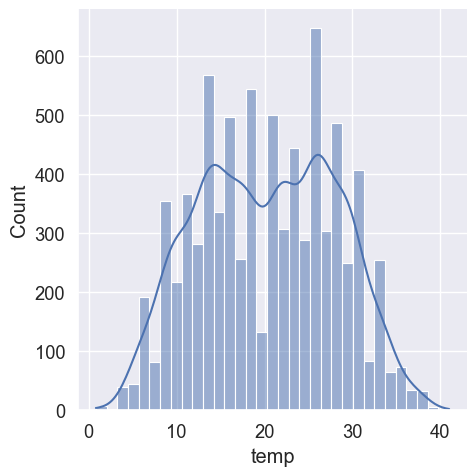

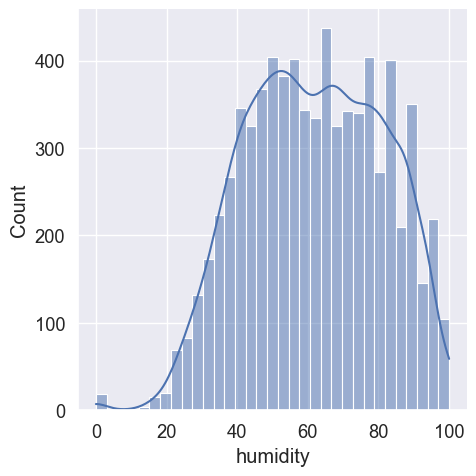

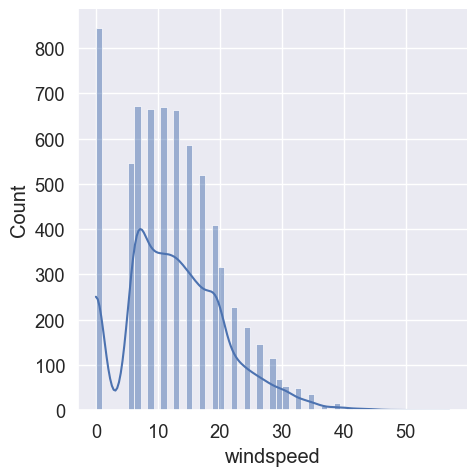

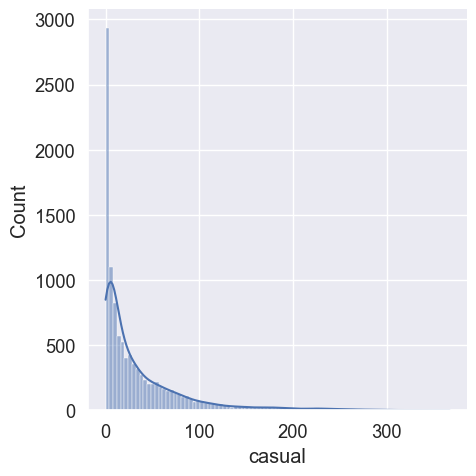

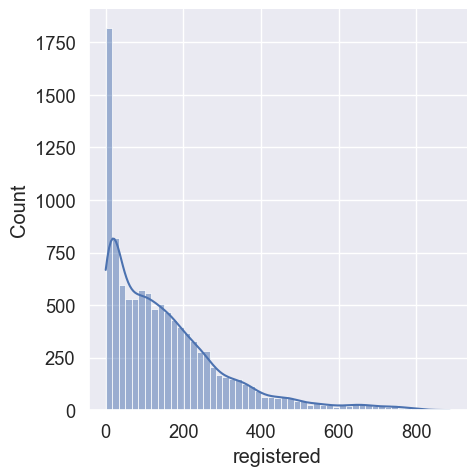

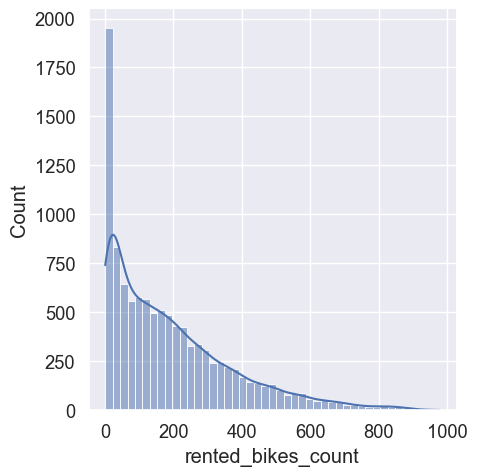

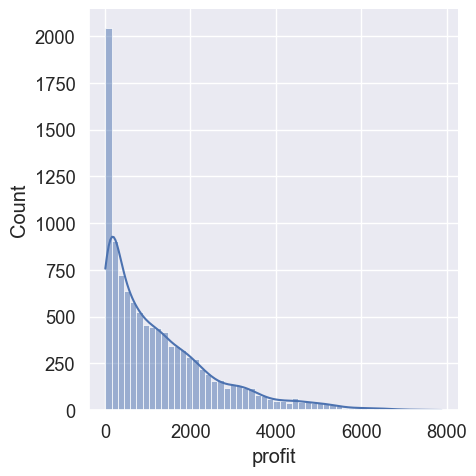

In [35]:
numerical_features = ['temp', 'humidity', 'windspeed', 'casual', 'registered', 'rented_bikes_count', 'profit']
for i, col in enumerate(numerical_features):
    sns.displot(data = df, x = col, kde=True, )
plt.tight_layout()
plt.show()

**Numerical Features - Bivariate**

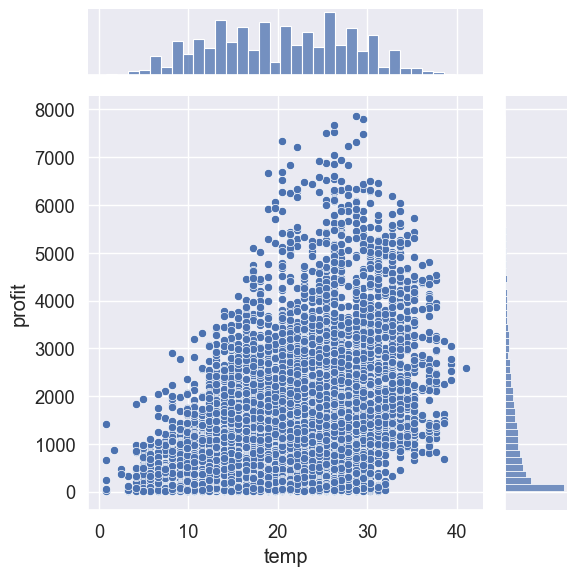

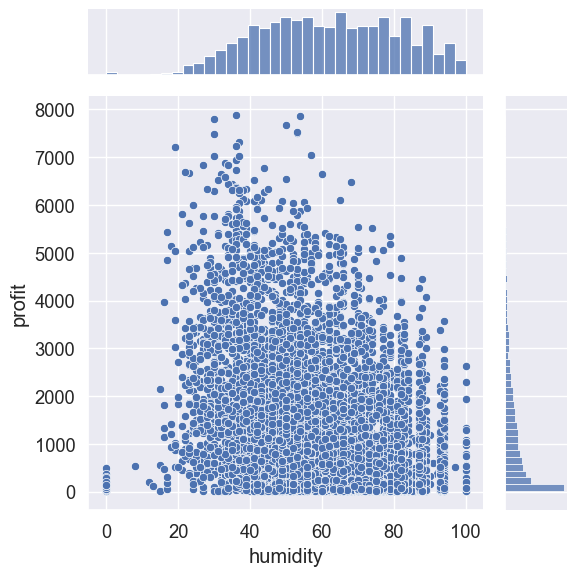

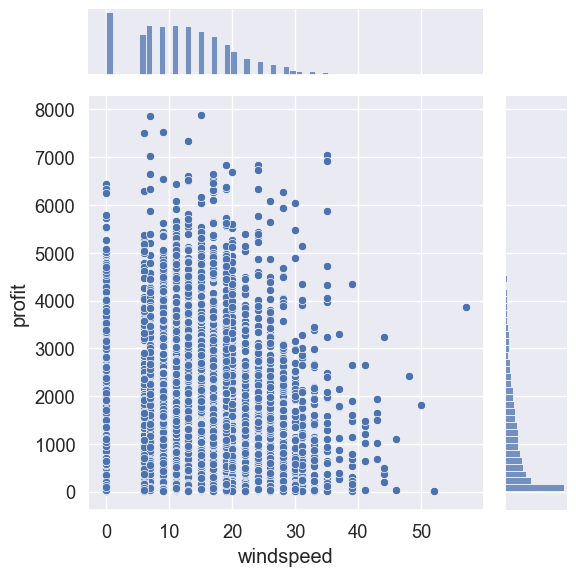

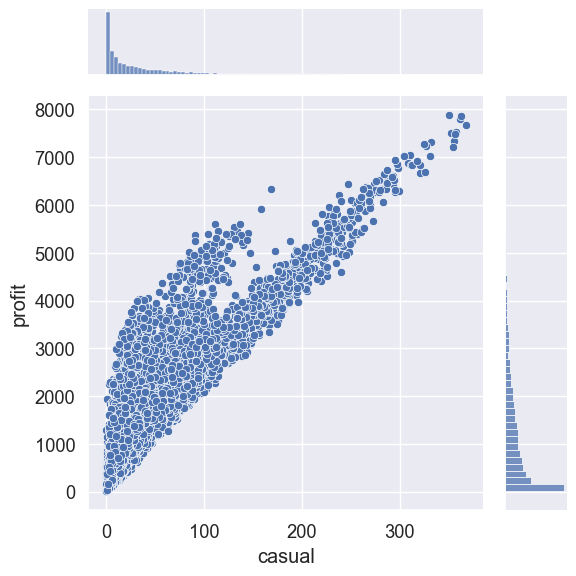

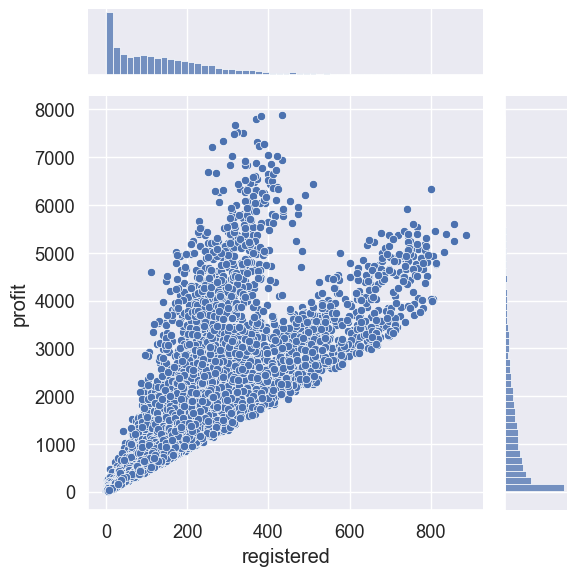

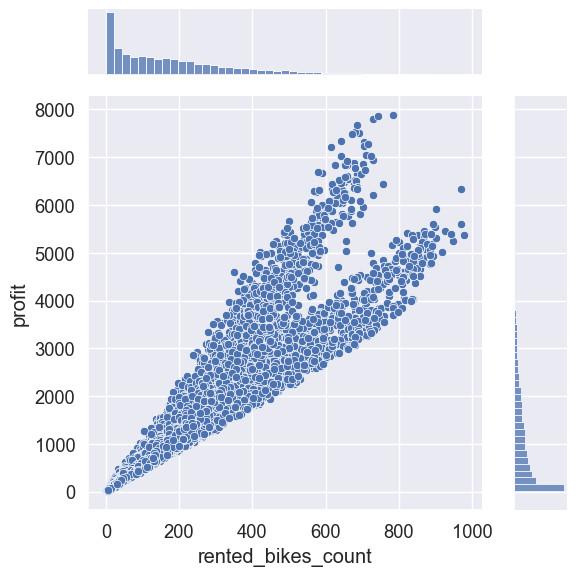

In [36]:
for i, col in enumerate(['temp', 'humidity', 'windspeed', 'casual', 'registered', 'rented_bikes_count']):
    sns.jointplot(data = df, x = col, y='profit')
    plt.tight_layout()
    plt.show()

**Categorical Features**
- year
- month_name
- day_of_week
- hour

**Categorical Features - Univarate**

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3396204114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = col, palette = 'mako')


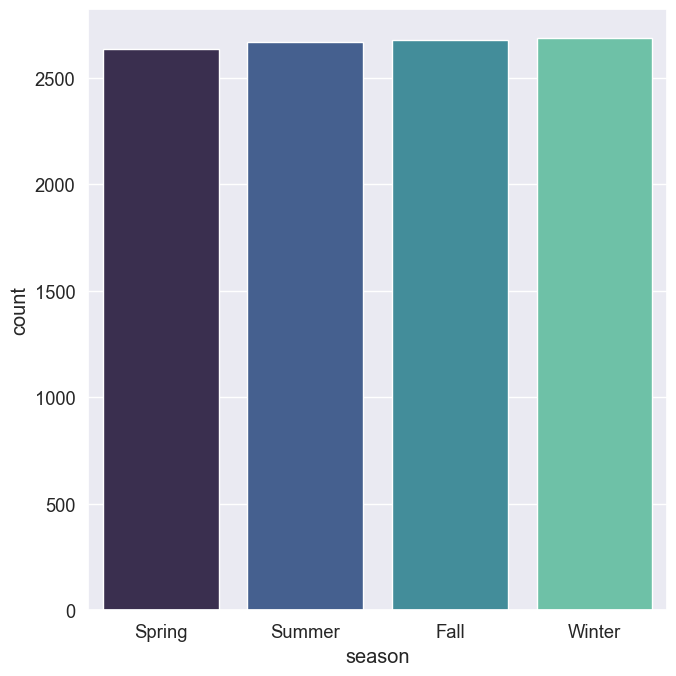

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3396204114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = col, palette = 'mako')


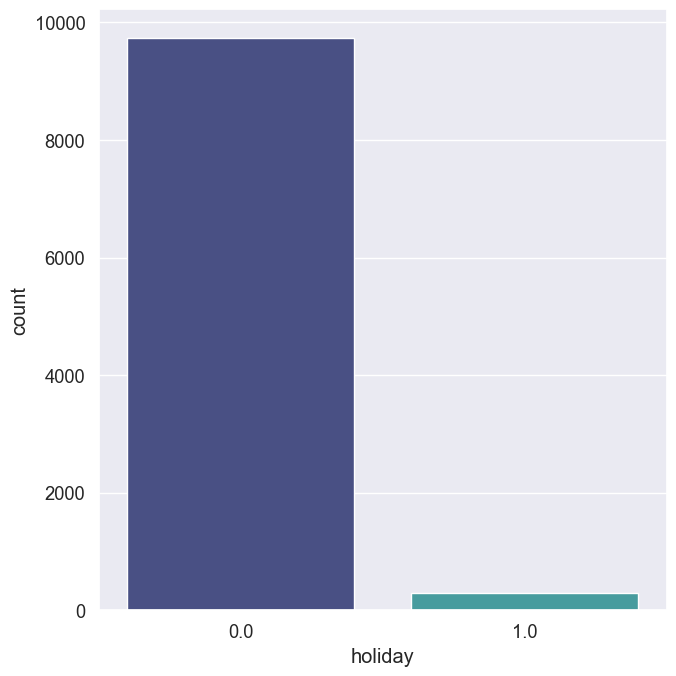

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3396204114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = col, palette = 'mako')


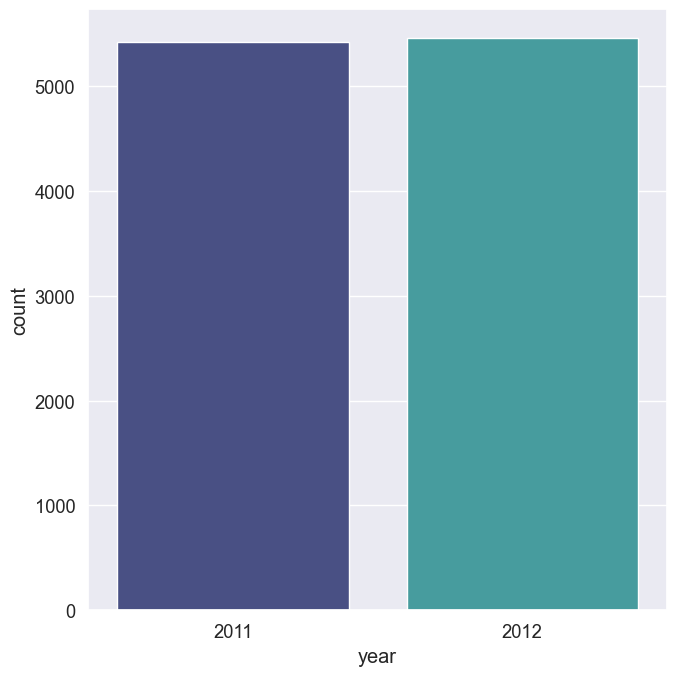

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3396204114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = col, palette = 'mako')


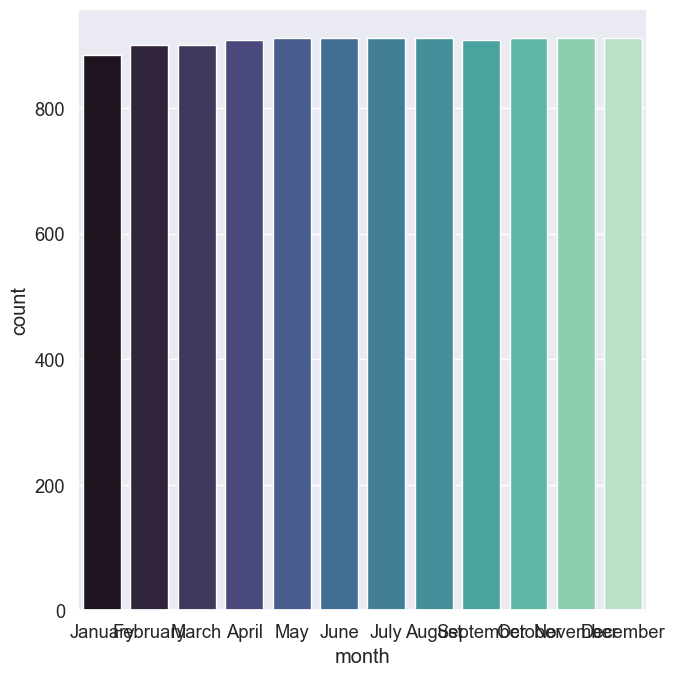

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3396204114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = col, palette = 'mako')


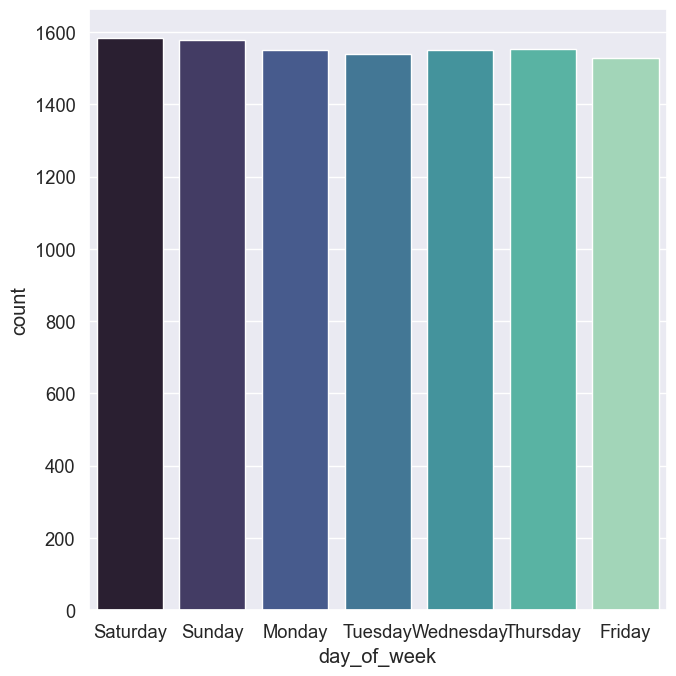

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3396204114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = col, palette = 'mako')


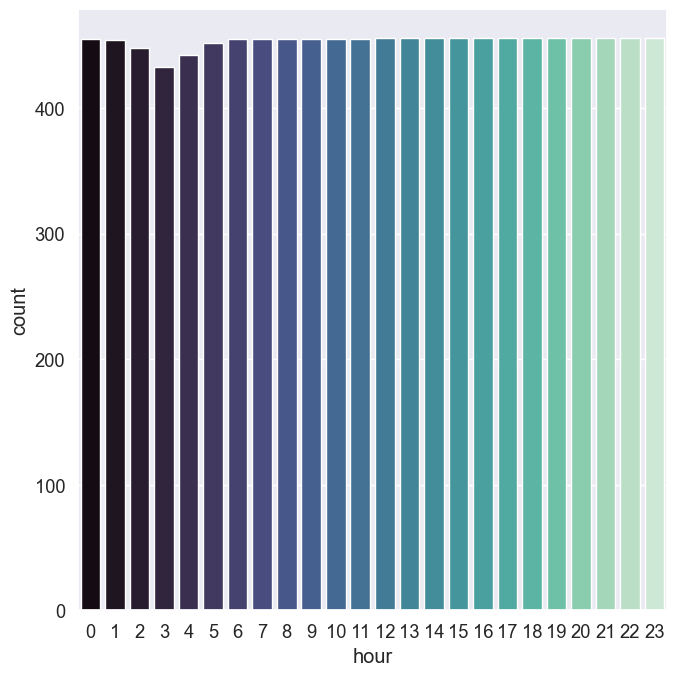

In [37]:
categorical_features = ['season', 'holiday', 'year', 'month', 'day_of_week', 'hour']
for i, col in enumerate(categorical_features):
    sns.countplot(data = df, x = col, palette = 'mako')
    plt.tight_layout()
    plt.show()

**Categorical Features - Bivarate**

In [38]:
categorical_features

['season', 'holiday', 'year', 'month', 'day_of_week', 'hour']

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\975239203.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x='season', y = 'profit', palette='mako')


<Axes: xlabel='season', ylabel='profit'>

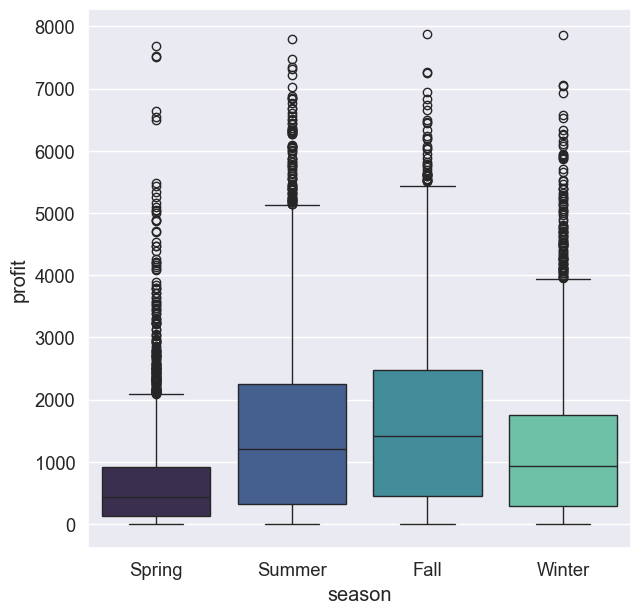

In [39]:
sns.boxplot(data = df, x='season', y = 'profit', palette='mako')

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\569389779.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x='weather', y = 'profit', palette='mako')


<Axes: xlabel='weather', ylabel='profit'>

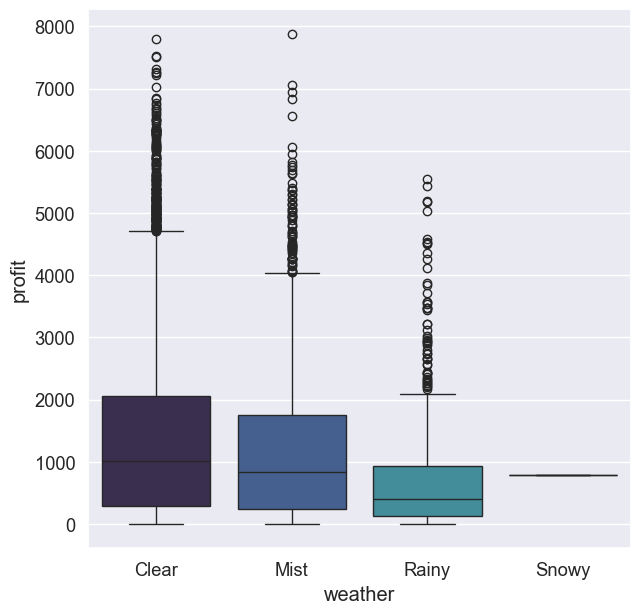

In [40]:
sns.boxplot(data = df, x='weather', y = 'profit', palette='mako')

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\2099908758.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x='holiday', y = 'profit', palette='mako')


<Axes: xlabel='holiday', ylabel='profit'>

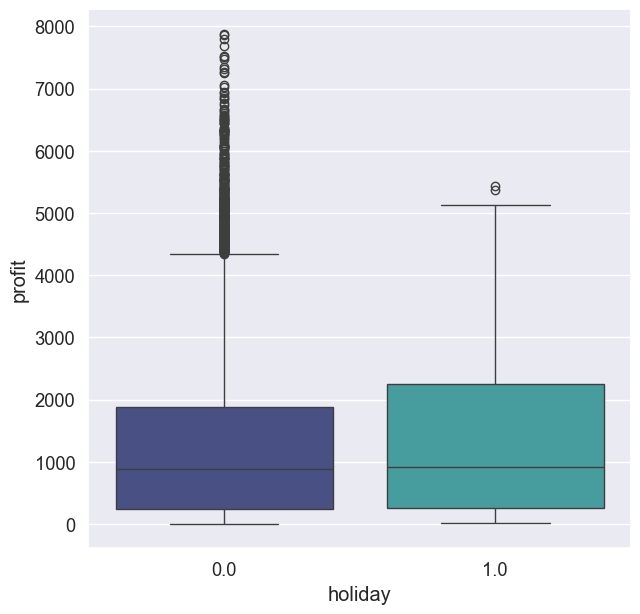

In [41]:
sns.boxplot(data = df, x='holiday', y = 'profit', palette='mako')

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3623679131.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x='year', y = 'profit', palette='mako')


<Axes: xlabel='year', ylabel='profit'>

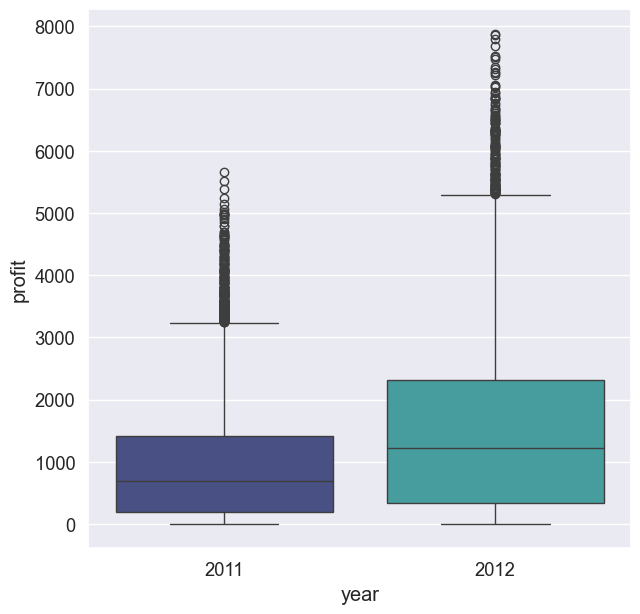

In [42]:
sns.boxplot(data = df, x='year', y = 'profit', palette='mako')

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\619459137.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig  = sns.boxplot(data = df, x='month', y = 'profit', palette='mako')
C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\619459137.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

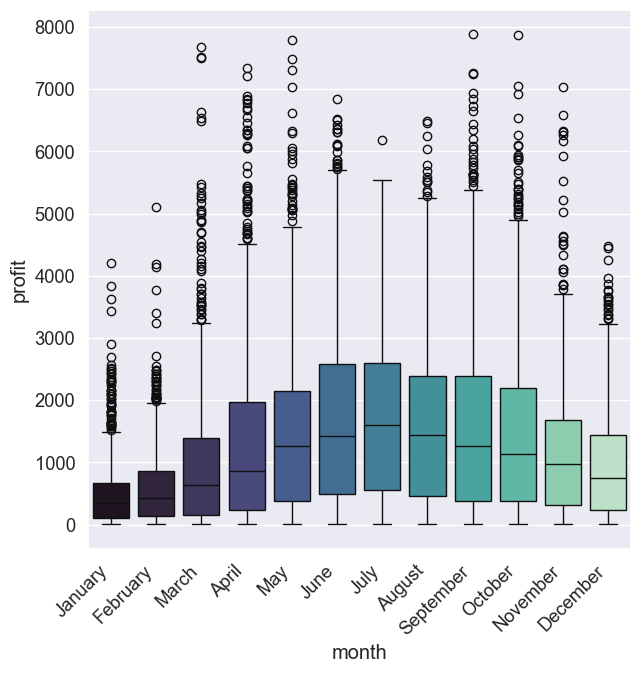

In [43]:
fig  = sns.boxplot(data = df, x='month', y = 'profit', palette='mako')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha='right')

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3676429927.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.boxplot(data = df, x='day_of_week', y = 'profit', palette='mako')
C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\3676429927.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha='right')


[Text(0, 0, 'Saturday'),
 Text(1, 0, 'Sunday'),
 Text(2, 0, 'Monday'),
 Text(3, 0, 'Tuesday'),
 Text(4, 0, 'Wednesday'),
 Text(5, 0, 'Thursday'),
 Text(6, 0, 'Friday')]

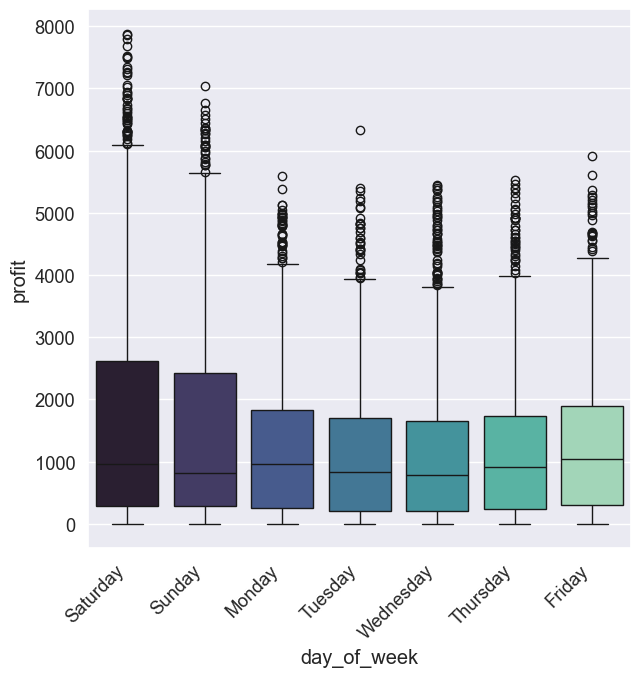

In [44]:
fig = sns.boxplot(data = df, x='day_of_week', y = 'profit', palette='mako')
fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha='right')

C:\Users\Mohamed Atef\AppData\Local\Temp\ipykernel_8100\1437679591.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x='hour', y = 'profit', palette='mako')


<Axes: xlabel='hour', ylabel='profit'>

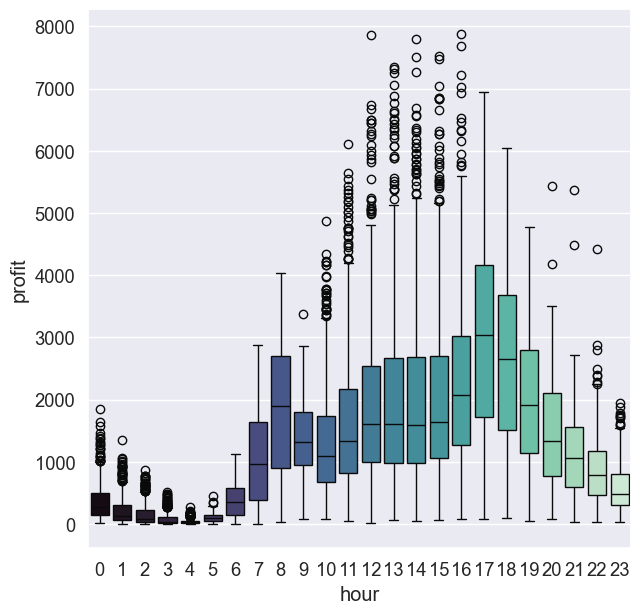

In [45]:
sns.boxplot(data = df, x='hour', y = 'profit', palette='mako')

**Matrix Plot**

In [46]:
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour,is_rush,is_school_day
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,107.324438,2011,January,Saturday,1,0,0,0
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0,8,32,40,275.024438,2011,January,Saturday,1,1,0,0
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0,5,27,32,201.924438,2011,January,Saturday,1,2,0,0
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0,3,10,13,94.424438,2011,January,Saturday,1,3,0,0
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,4.124438,2011,January,Saturday,1,4,0,0


In [47]:
new_df = pd.pivot_table(data = df, values='profit', index='month', columns='day_of_week')
new_df

day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,1154.446105,1347.056833,1564.092772,1901.678605,1298.496105,1145.923744,1017.442926
August,1620.506383,1476.014438,2177.201105,1696.926938,1571.295272,1531.126105,1557.708466
December,939.051938,946.690410,1147.237633,884.549438,913.538605,1018.279438,872.939438
February,720.242169,575.345491,663.457772,565.581581,561.277255,537.579523,589.923734
January,562.118055,391.093942,583.119438,507.164298,565.979060,471.266958,422.944438
July,1685.603605,1703.998049,2129.256105,1874.833466,1607.128605,1472.454994,1682.378605
June,1574.998049,1474.724438,2399.463327,2142.538327,1422.156938,1441.435272,1451.253605
March,819.216692,968.417659,1401.714022,1258.989395,873.239227,759.298388,865.642085
May,1653.998605,1172.971938,2287.961938,1791.419438,1477.262633,1251.990410,1189.401522


<Axes: xlabel='day_of_week', ylabel='month'>

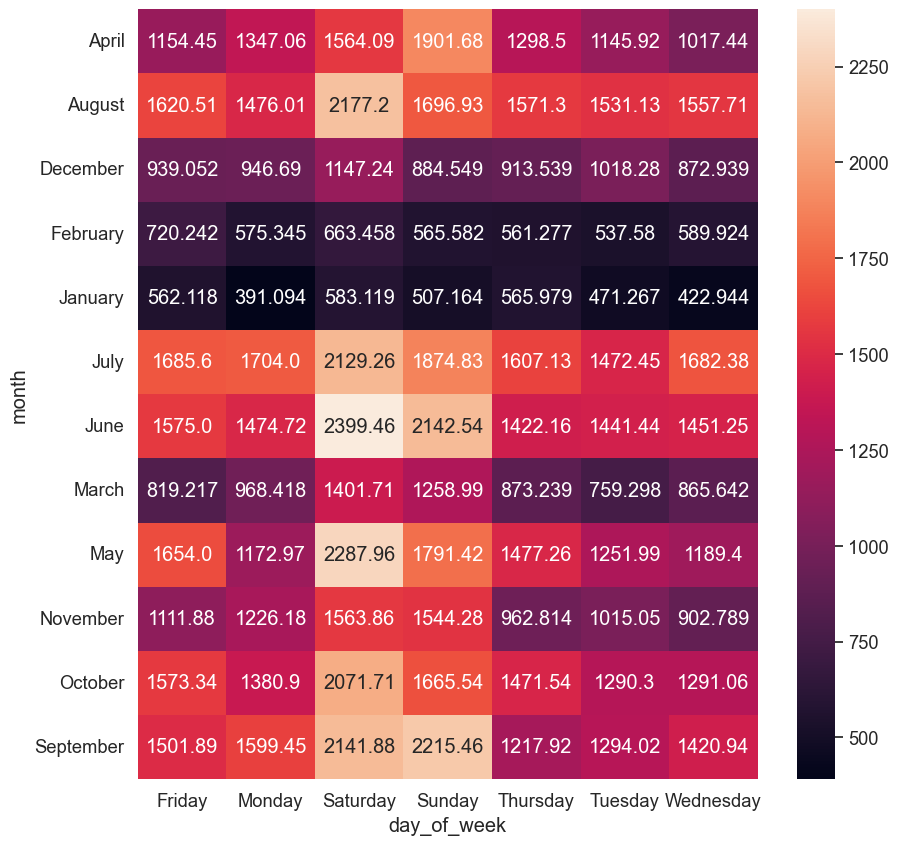

In [48]:
sns.set(rc={'figure.figsize':[10, 10]}, font_scale = 1.2)
sns.heatmap(new_df, annot=True, fmt='0.6')

# Data Preprocessing
- Data Cleaning or Cleansing
- Work with Missing data
- Work with Categorical data
- Detect and Handel Outliers
- Split data to Train and test Sets
- Feature Scaling

In [49]:
# Dataa Cleaning and Cleansing
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour,is_rush,is_school_day
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.84,81.0,NaN,3,13,16,107.324438,2011,January,Saturday,1,0,0,0
1,2011-01-01 01:00:00,Spring,0.0,0.0,NaN,9.02,80.0,0.0,8,32,40,275.024438,2011,January,Saturday,1,1,0,0
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.02,NaN,0.0,5,27,32,201.924438,2011,January,Saturday,1,2,0,0
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.84,75.0,0.0,3,10,13,94.424438,2011,January,Saturday,1,3,0,0
4,2011-01-01 04:00:00,NaN,0.0,0.0,Clear,NaN,75.0,NaN,0,1,1,4.124438,2011,January,Saturday,1,4,0,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            10886 non-null  datetime64[ns]
 1   season              10672 non-null  object        
 2   holiday             10030 non-null  float64       
 3   workingday          9388 non-null   float64       
 4   weather             8746 non-null   object        
 5   temp                8104 non-null   float64       
 6   humidity            7462 non-null   float64       
 7   windspeed           6820 non-null   float64       
 8   casual              10886 non-null  int64         
 9   registered          10886 non-null  int64         
 10  rented_bikes_count  10886 non-null  int64         
 11  profit              10886 non-null  float64       
 12  year                10886 non-null  int32         
 13  month               10886 non-null  object    

## Numeric Features Cleaning
- Use to_numeric to check the Numeric features value

In [51]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'rented_bikes_count',
       'profit', 'year', 'month', 'day_of_week', 'day', 'hour', 'is_rush',
       'is_school_day'],
      dtype='object')

In [52]:
for col in ['temp','humidity', 'windspeed', 'casual', 'registered', 'rented_bikes_count','profit']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            10886 non-null  datetime64[ns]
 1   season              10672 non-null  object        
 2   holiday             10030 non-null  float64       
 3   workingday          9388 non-null   float64       
 4   weather             8746 non-null   object        
 5   temp                8104 non-null   float64       
 6   humidity            7462 non-null   float64       
 7   windspeed           6820 non-null   float64       
 8   casual              10886 non-null  int64         
 9   registered          10886 non-null  int64         
 10  rented_bikes_count  10886 non-null  int64         
 11  profit              10886 non-null  float64       
 12  year                10886 non-null  int32         
 13  month               10886 non-null  object    

In [53]:
df.describe()

,datetime,holiday,workingday,temp,humidity,windspeed,casual,registered,rented_bikes_count,profit,year,day,hour,is_rush,is_school_day
count,10886,10030.000000,9388.000000,8104.000000,7462.000000,6820.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,0.029113,0.678206,20.317665,61.790673,12.708806,36.021955,155.552177,191.574132,1288.276422,2011.501929,9.992559,11.541613,0.251056,0.751240
min,2011-01-01 00:00:00,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,0.000000,1.000000,4.124438,2011.000000,1.000000,0.000000,0.000000,0.000000
25%,2011-07-02 07:15:00,0.000000,0.000000,13.940000,47.000000,7.001500,4.000000,36.000000,42.000000,253.524438,2011.000000,5.000000,6.000000,0.000000,1.000000
50%,2012-01-01 20:30:00,0.000000,1.000000,20.500000,62.000000,12.998000,17.000000,118.000000,145.000000,889.924438,2012.000000,10.000000,12.000000,0.000000,1.000000
75%,2012-07-01 12:45:00,0.000000,1.000000,26.240000,77.000000,16.997900,49.000000,222.000000,284.000000,1891.824438,2012.000000,15.000000,18.000000,1.000000,1.000000
max,2012-12-19 23:00:00,1.000000,1.000000,41.000000,100.000000,56.996900,367.000000,886.000000,977.000000,7881.724438,2012.000000,19.000000,23.000000,1.000000,1.000000
std,NaN,0.168131,0.467189,7.818568,19.262084,8.131154,49.960477,151.039033,181.144454,1309.683400,0.500019,5.476608,6.915838,0.433641,0.432314


## Categorical Features Cleaning
- Use unique to check the Categorical features value

In [54]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'rented_bikes_count',
       'profit', 'year', 'month', 'day_of_week', 'day', 'hour', 'is_rush',
       'is_school_day'],
      dtype='object')

In [55]:
for col in['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day_of_week', 'day', 'hour', 'is_rush', 'is_school_day']:
    print(f'----{col}----')
    print(df[col].unique())
    print('=========================')

----season----
['Spring' nan 'Summer' 'Fall' 'Winter']
----holiday----
[ 0. nan  1.]
----workingday----
[ 0. nan  1.]
----weather----
['Clear' nan 'Mist' 'Rainy' 'Snowy']
----year----
[2011 2012]
----month----
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
----day_of_week----
['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday']
----day----
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
----hour----
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
----is_rush----
[0 1]
----is_school_day----
[0 1]


## Missing Data

In [56]:
df.isnull().sum()

datetime                 0
season                 214
holiday                856
workingday            1498
weather               2140
temp                  2782
humidity              3424
windspeed             4066
casual                   0
registered               0
rented_bikes_count       0
profit                   0
year                     0
month                    0
day_of_week              0
day                      0
hour                     0
is_rush                  0
is_school_day            0
dtype: int64

In [57]:
# Drop windspeed column
df.drop('windspeed', axis=1, inplace=True)

In [58]:
# Drop null values in season column
df.dropna(subset=['season'], axis=0, inplace=True)

In [59]:
imputer = KNNImputer()

for col in['holiday', 'workingday', 'temp', 'humidity']:
    df[col] = imputer.fit_transform(df[[col]])

In [60]:
# df['weather'].fillna (df ['weather'].mode()[0], inplace=True)
df['weather'] = df['weather'].fillna('mode')

In [61]:
df.isnull().sum()

datetime              0
season                0
holiday               0
workingday            0
weather               0
temp                  0
humidity              0
casual                0
registered            0
rented_bikes_count    0
profit                0
year                  0
month                 0
day_of_week           0
day                   0
hour                  0
is_rush               0
is_school_day         0
dtype: int64

## Handle Categorical Features

In [62]:
df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,casual,registered,rented_bikes_count,profit,year,month,day_of_week,day,hour,is_rush,is_school_day
0,2011-01-01 00:00:00,Spring,0.0,0.0,Clear,9.840000,81.000000,3,13,16,107.324438,2011,January,Saturday,1,0,0,0
1,2011-01-01 01:00:00,Spring,0.0,0.0,mode,9.020000,80.000000,8,32,40,275.024438,2011,January,Saturday,1,1,0,0
2,2011-01-01 02:00:00,Spring,0.0,0.0,Clear,9.020000,61.849829,5,27,32,201.924438,2011,January,Saturday,1,2,0,0
3,2011-01-01 03:00:00,Spring,0.0,0.0,Clear,9.840000,75.000000,3,10,13,94.424438,2011,January,Saturday,1,3,0,0
6,2011-01-01 06:00:00,Spring,0.0,0.0,Clear,20.299854,61.849829,2,0,2,34.224438,2011,January,Saturday,1,6,0,0


In [63]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'casual', 'registered', 'rented_bikes_count', 'profit',
       'year', 'month', 'day_of_week', 'day', 'hour', 'is_rush',
       'is_school_day'],
      dtype='object')

In [64]:
df = df[['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'rented_bikes_count', 'profit','year', 'month', 'day_of_week', 'hour']]
df

,season,holiday,workingday,weather,temp,humidity,rented_bikes_count,profit,year,month,day_of_week,hour
0,Spring,0.000000,0.0,Clear,9.840000,81.000000,16,107.324438,2011,January,Saturday,0
1,Spring,0.000000,0.0,mode,9.020000,80.000000,40,275.024438,2011,January,Saturday,1
2,Spring,0.000000,0.0,Clear,9.020000,61.849829,32,201.924438,2011,January,Saturday,2
3,Spring,0.000000,0.0,Clear,9.840000,75.000000,13,94.424438,2011,January,Saturday,3
6,Spring,0.000000,0.0,Clear,20.299854,61.849829,2,34.224438,2011,January,Saturday,6
...,...,...,...,...,...,...,...,...,...,...,...,...
10880,Winter,0.000000,1.0,mode,15.580000,61.849829,569,2743.224438,2012,December,Wednesday,18
10881,Winter,0.000000,1.0,Clear,15.580000,50.000000,336,1534.924438,2012,December,Wednesday,19
10882,Winter,0.000000,1.0,mode,14.760000,61.849829,241,1165.124438,2012,December,Wednesday,20
10884,Winter,0.028868,1.0,Clear,13.940000,61.849829,129,709.324438,2012,December,Wednesday,22


In [65]:
df['month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [66]:
df = pd.get_dummies(df, columns=['season', 'weather', 'day_of_week'], drop_first=True)

month_dict={
    'January':1, 
    'February':2, 
    'March':3, 
    'April':4, 
    'May':5, 
    'June':6, 
    'July':7,
    'August':8, 
    'September':9, 
    'October':10, 
    'November':11, 
    'December':12
}
    

df['month'] = df['month'].map(month_dict)
df

,holiday,workingday,temp,humidity,rented_bikes_count,profit,year,month,hour,season_Spring,...,weather_Mist,weather_Rainy,weather_Snowy,weather_mode,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,0.000000,0.0,9.840000,81.000000,16,107.324438,2011,1,0,True,...,False,False,False,False,False,True,False,False,False,False
1,0.000000,0.0,9.020000,80.000000,40,275.024438,2011,1,1,True,...,False,False,False,True,False,True,False,False,False,False
2,0.000000,0.0,9.020000,61.849829,32,201.924438,2011,1,2,True,...,False,False,False,False,False,True,False,False,False,False
3,0.000000,0.0,9.840000,75.000000,13,94.424438,2011,1,3,True,...,False,False,False,False,False,True,False,False,False,False
6,0.000000,0.0,20.299854,61.849829,2,34.224438,2011,1,6,True,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10880,0.000000,1.0,15.580000,61.849829,569,2743.224438,2012,12,18,False,...,False,False,False,True,False,False,False,False,False,True
10881,0.000000,1.0,15.580000,50.000000,336,1534.924438,2012,12,19,False,...,False,False,False,False,False,False,False,False,False,True
10882,0.000000,1.0,14.760000,61.849829,241,1165.124438,2012,12,20,False,...,False,False,False,True,False,False,False,False,False,True
10884,0.028868,1.0,13.940000,61.849829,129,709.324438,2012,12,22,False,...,False,False,False,False,False,False,False,False,False,True


## Split data to Train and Test Sets

In [67]:
x = df.drop('profit', axis = 1)
y = df['profit']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [68]:
x_train.shape

(8537, 21)

In [69]:
x_test.shape

(2135, 21)

In [70]:
y_train.shape

(8537,)

In [71]:
y_test.shape

(2135,)

## Features Scaling

In [72]:
scaler = StandardScaler()

scaler.fit(x_train)

x_train = scaler.transform(x_train)

x_test = scaler.transform(x_test)

In [73]:
x_train

array([[-0.17956827,  0.74580455, -0.00272414, ..., -0.40265252,
        -0.40833197, -0.40441883],
       [-0.17956827,  0.74580455,  1.48689021, ...,  2.48353098,
        -0.40833197, -0.40441883],
       [-0.17956827,  0.00520877, -0.00272414, ..., -0.40265252,
         2.44898775, -0.40441883],
       ...,
       [-0.17956827,  0.74580455, -0.00272414, ...,  2.48353098,
        -0.40833197, -0.40441883],
       [-0.17956827,  0.74580455, -0.82464903, ..., -0.40265252,
        -0.40833197, -0.40441883],
       [-0.17956827, -1.55476958, -0.00272414, ..., -0.40265252,
        -0.40833197, -0.40441883]])

# Machine Learning

## Model

In [74]:
models ={
    'Linear Regression' :  LinearRegression(),
    'SVM' : SVR(),
    'KNN' : KNeighborsRegressor(),
    'Decision Tree' : DecisionTreeRegressor(),
    'Random Forest' : RandomForestRegressor(),
    'XGB' : XGBRFRegressor(),
}

In [75]:
for name, model in models.items():
    print(f'Model: {name}')
    print('_' * 20)
    model.fit(x_train, y_train)
    
    y_predict_test = model.predict(x_test)
    y_predict_train = model.predict(x_train)
    
    print(f'Train MAE : {mean_absolute_error(y_train, y_predict_train)}')
    print(f'Test MAE : {mean_absolute_error(y_test, y_predict_test)}')
    
    print(f'Train RMSE : {np.sqrt(mean_squared_error(y_train, y_predict_train))}')
    print(f'Test RMSE : {np.sqrt(mean_squared_error(y_test, y_predict_test))}')
    
    print(f'Train R2 Score : {r2_score(y_train, y_predict_train)}')
    print(f'Test R2 Score : {r2_score(y_test, y_predict_test)}')

    print(f'Train Score : {model.score(x_train, y_train)}')
    print(f'Test Sore : {model.score(x_test, y_test)}')
    
    print('\n')

Model: Linear Regression
____________________
Train MAE : 272.4967662197966
Test MAE : 268.0769348445312
Train RMSE : 387.0645008862737
Test RMSE : 381.80738898940353
Train R2 Score : 0.9131673790294266
Test R2 Score : 0.9128177238682317
Train Score : 0.9131673790294266
Test Sore : 0.9128177238682317


Model: SVM
____________________
Train MAE : 819.870781497851
Test MAE : 813.9758963000505
Train RMSE : 1219.360028785106
Test RMSE : 1203.5726733858794
Train R2 Score : 0.13825229729117794
Test R2 Score : 0.1336683460570003
Train Score : 0.13825229729117794
Test Sore : 0.1336683460570003


Model: KNN
____________________
Train MAE : 236.0154503924095
Test MAE : 293.90812177985947
Train RMSE : 348.4973216158674
Test RMSE : 424.2840197244486
Train R2 Score : 0.9296093274699853
Test R2 Score : 0.8923403670007692
Train Score : 0.9296093274699853
Test Sore : 0.8923403670007692


Model: Decision Tree
____________________
Train MAE : 1.1527488450600197e-16
Test MAE : 137.50936768149882
Train RM

## Random Forest is the best Model for Prediction

In [76]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [77]:
model.predict(x_test)

array([1233.1934382,  267.0694382, 1875.3984382, ..., 2693.8174382,
       2182.8054382, 1947.5094382])

In [78]:
y_test

2533     1367.224438
441       244.924438
6321     2184.224438
10118    1126.424438
10621     928.624438
            ...     
8369       81.524438
1165        8.424438
4622     3091.524438
3346     2201.424438
6419     1762.824438
Name: profit, Length: 2135, dtype: float64

# Saving Model and Scaler

In [79]:
joblib.dump(model, 'model.h5')

['model.h5']

In [80]:
joblib.dump(scaler, 'scaler.h5')

['scaler.h5']

In [81]:
joblib.dump(x.columns, 'inputs.h5')

['inputs.h5']

In [82]:
x.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'rented_bikes_count',
       'year', 'month', 'hour', 'season_Spring', 'season_Summer',
       'season_Winter', 'weather_Mist', 'weather_Rainy', 'weather_Snowy',
       'weather_mode', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday'],
      dtype='object')